In [1]:
#Importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from scipy.stats.mstats import winsorize
from sklearn import preprocessing   
from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
%matplotlib inline

In [18]:
#Create dataframe of the dataset
df = pd.read_csv('instagram_reach.csv')

In [3]:
#Fetchiing 1st 5 rows of data
df.head()

,Unnamed: 0,S.No,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,0,1,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,11 hours,139
1,1,2,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,2 hours,23
2,2,3,aitrading_official,Alexander Barinov: 4 years as CFO in multinati...,255,#whoiswho #aitrading #ai #aitradingteam#instat...,2 hours,25
3,3,4,opensourcedworkplace,sfad,340,#iot #cre#workplace #CDO #bigdata #technology#...,3 hours,49
4,4,5,crea.vision,Ever missed a call while your phone was chargi...,304,#instamachinelearning #instabigdata#instamarke...,3 hours,30


In [4]:
df.shape

(100, 8)

In [5]:
# Missing value detection
df.isnull().sum()

Unnamed: 0           0
S.No                 0
USERNAME             0
Caption              6
Followers            0
Hashtags             0
Time since posted    0
Likes                0
dtype: int64

In [6]:
#Checking if there any duplicated value
df.duplicated().sum()

0

In [7]:
#Brief info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         100 non-null    int64 
 1   S.No               100 non-null    int64 
 2   USERNAME           100 non-null    object
 3   Caption            94 non-null     object
 4   Followers          100 non-null    int64 
 5   Hashtags           100 non-null    object
 6   Time since posted  100 non-null    object
 7   Likes              100 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 6.4+ KB


In [8]:
#Creating a copy of original dataframe for better practice
data = df.copy()

In [9]:
#Filling null value as unknown
data['Caption'].fillna("Unknown", inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         100 non-null    int64 
 1   S.No               100 non-null    int64 
 2   USERNAME           100 non-null    object
 3   Caption            100 non-null    object
 4   Followers          100 non-null    int64 
 5   Hashtags           100 non-null    object
 6   Time since posted  100 non-null    object
 7   Likes              100 non-null    int64 
dtypes: int64(4), object(4)
memory usage: 6.4+ KB


In [11]:
data.head(2)

,Unnamed: 0,S.No,USERNAME,Caption,Followers,Hashtags,Time since posted,Likes
0,0,1,mikequindazzi,Who are #DataScientist and what do they do? >>...,1600,#MachineLearning #AI #DataAnalytics #DataScien...,11 hours,139
1,1,2,drgorillapaints,We all know where it’s going. We just have to ...,880,#deck .#mac #macintosh#sayhello #apple #steve...,2 hours,23


In [12]:
#Convert Time since posted to hours
data['hours'] = data['Time since posted'].str.split().str[0]

#hours column is object datatype so convert it into int
data.hours = data.hours.astype(int)

In [13]:
#Drop the Time since posted column as it is not necessary
data = data.drop('Time since posted', axis=1)

In [14]:
#Drop the S.no column as it is not necessary
data = data.drop('S.No', axis=1)

In [15]:
#Drop the Unnamed: 0 column as it is not necessary
data = data.drop('Unnamed: 0', axis=1)

In [16]:
data.columns

Index(['USERNAME', 'Caption', 'Followers', 'Hashtags', 'Likes', 'hours'], dtype='object')

In [19]:
data.shape

(100, 6)

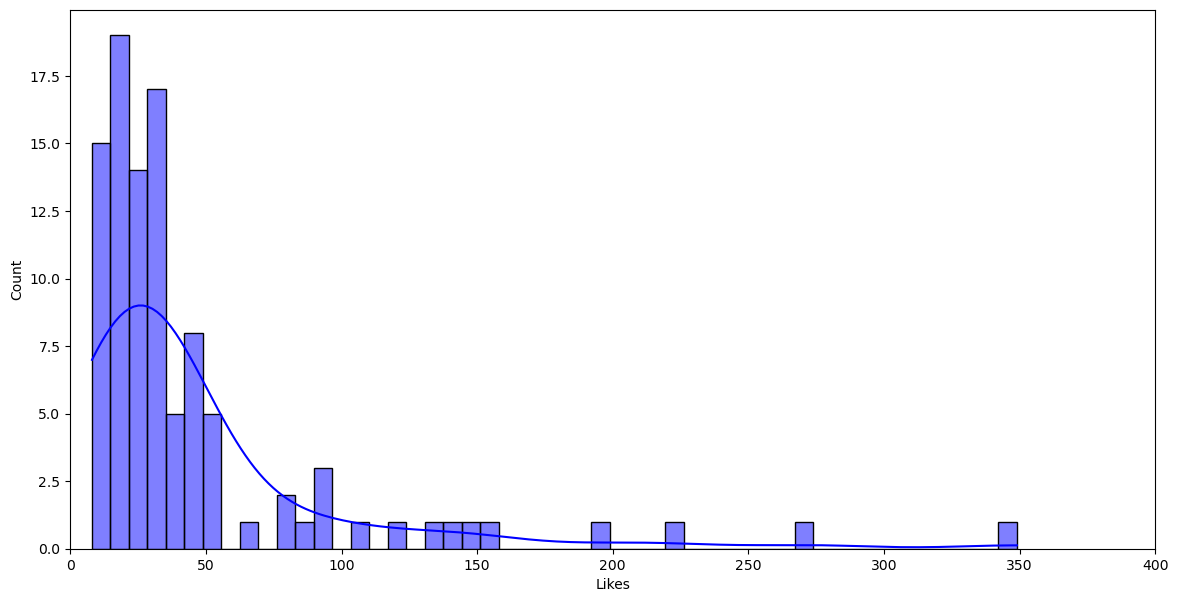

In [20]:
plt.subplots(figsize=(14,7))
sns.histplot(data.Likes, bins=50, kde=True, color = 'b')
plt.xlim(0,400)
plt.show()

Observation:

Most of users has 0 to 50 likes and very few users has 200 to 350 likes.

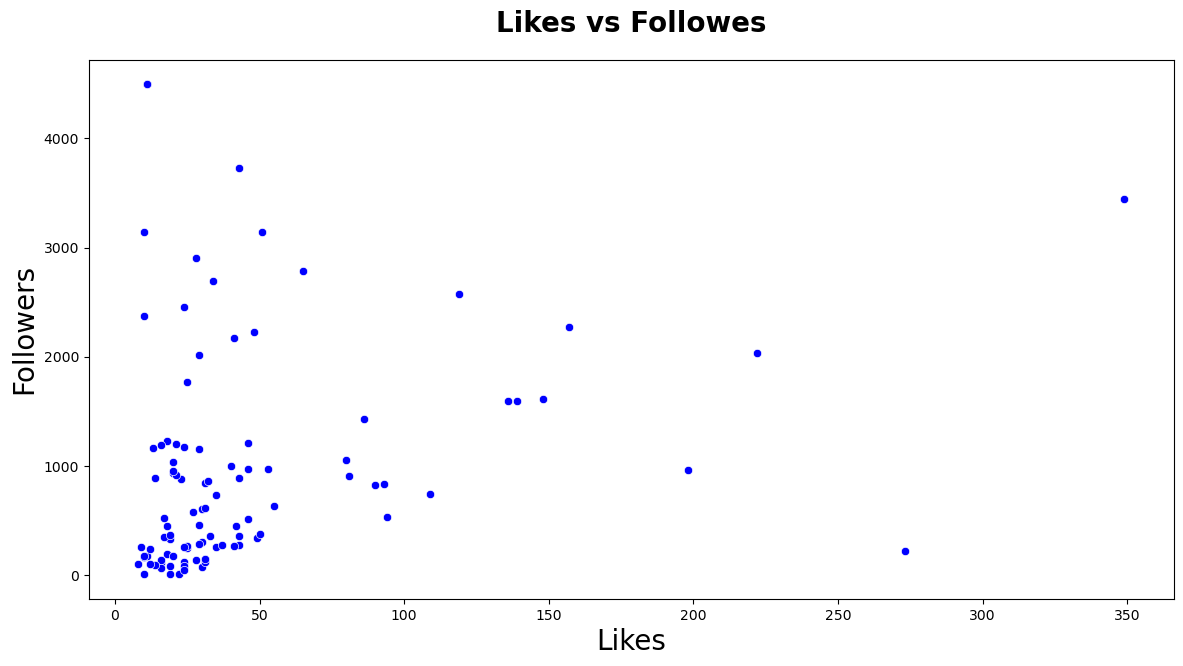

In [21]:
plt.subplots(figsize=(14,7))
sns.scatterplot(x="Likes", y='Followers', data=data,ec = "white",color='b')
plt.title("Likes vs Followes", weight="bold",fontsize=20, pad=20)
plt.ylabel("Followers", fontsize=20)
plt.xlabel("Likes", fontsize=20)
plt.show()

Observation:

Less follower user has less likes and user having more follower has approximately more likes.

# Finding outliers

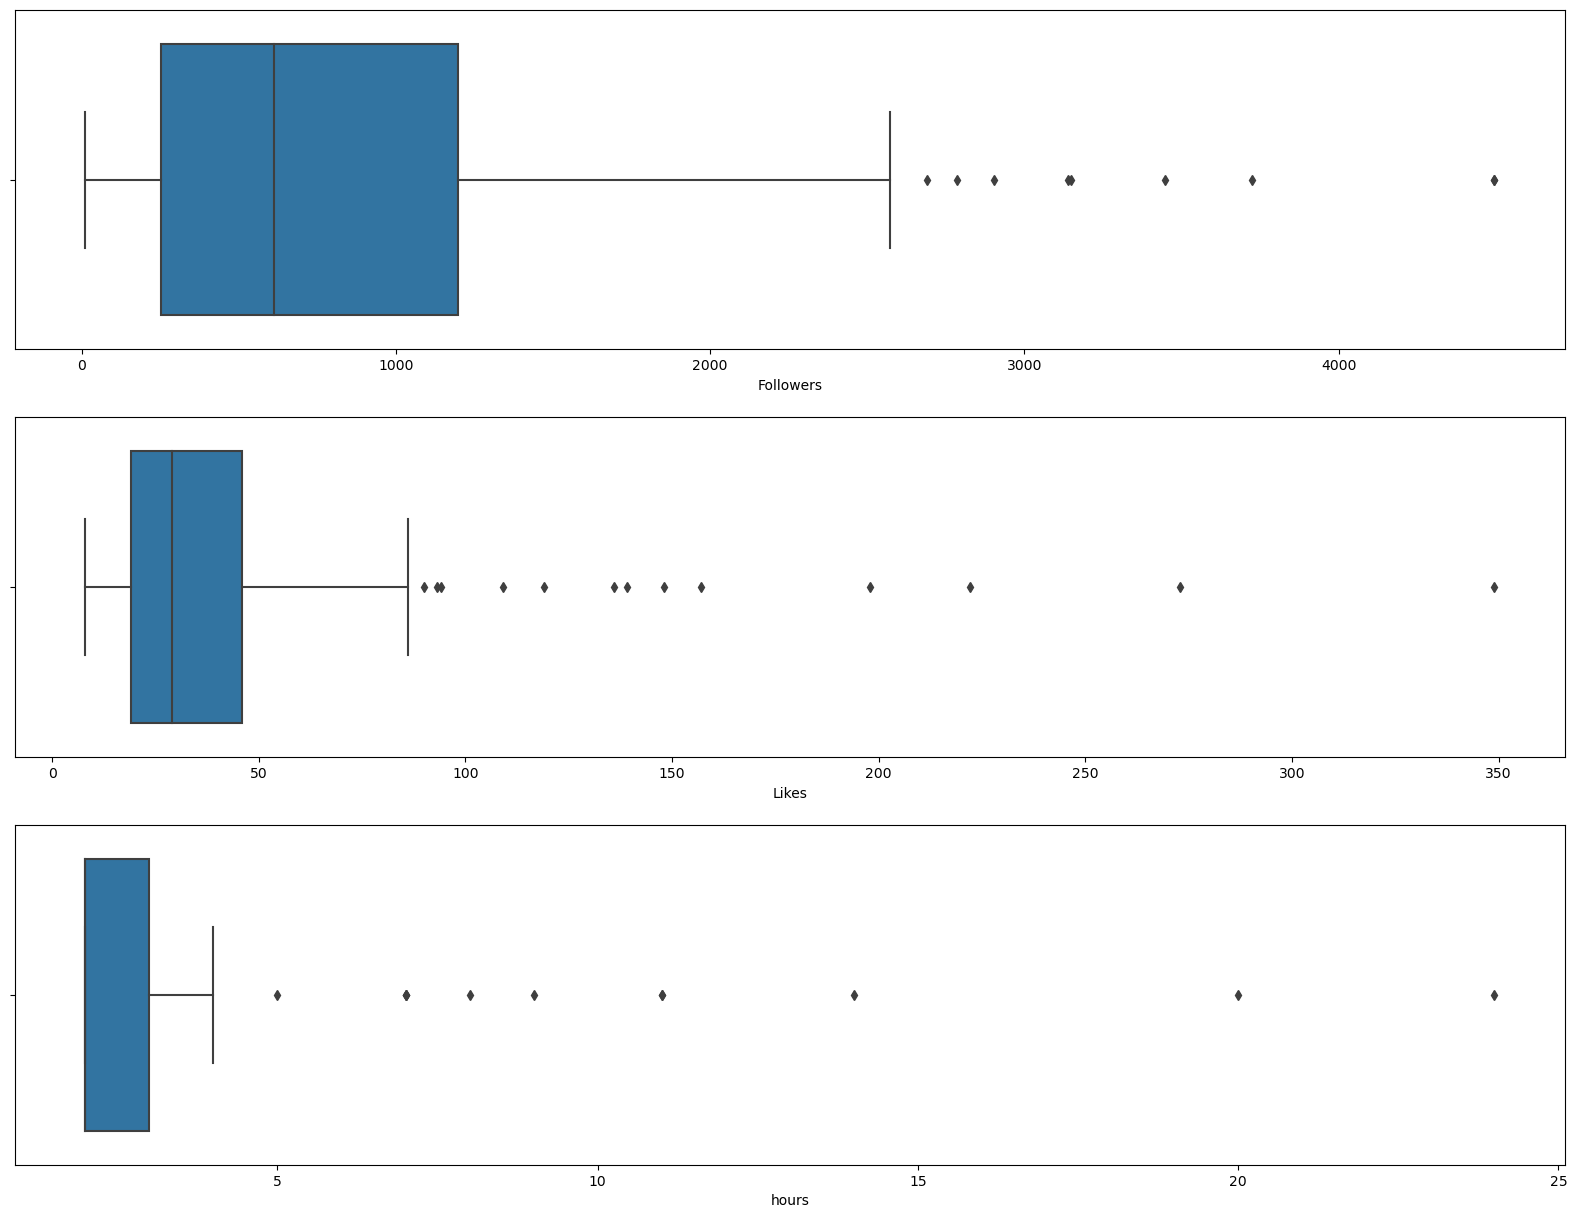

In [24]:
# Plot Boxplot of 'Followers', 'Likes', 'hours' column
numerical_col = ['Followers', 'Likes', 'hours']

fig = plt.figure(figsize=[20,15])
for i ,col in enumerate(numerical_col):  
    ax1 = fig.add_subplot(3,1, i+1);
    ax1 = sns.boxplot(data = data, x=col)

# Handling Outliers

In [25]:
# Calculate IQR for numerical columns
Q1 = data[numerical_col].quantile(0.25)
Q3 = data[numerical_col].quantile(0.75)
IQR = Q3 - Q1

# Remove data points outside the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[~((data[numerical_col] < lower_bound) | (data[numerical_col] > upper_bound)).any(axis=1)]

In [26]:
lower_percentile = 5
upper_percentile = 95

# Calculate lower and upper bounds based on percentiles
lower_bound = data[numerical_col].quantile(lower_percentile / 100)
upper_bound = data[numerical_col].quantile(upper_percentile / 100)

# Replace values below lower percentile with lower bound and values above upper percentile with upper bound
data[numerical_col] = np.where(data[numerical_col] < lower_bound, lower_bound, data[numerical_col])
data[numerical_col] = np.where(data[numerical_col] > upper_bound, upper_bound, data[numerical_col])

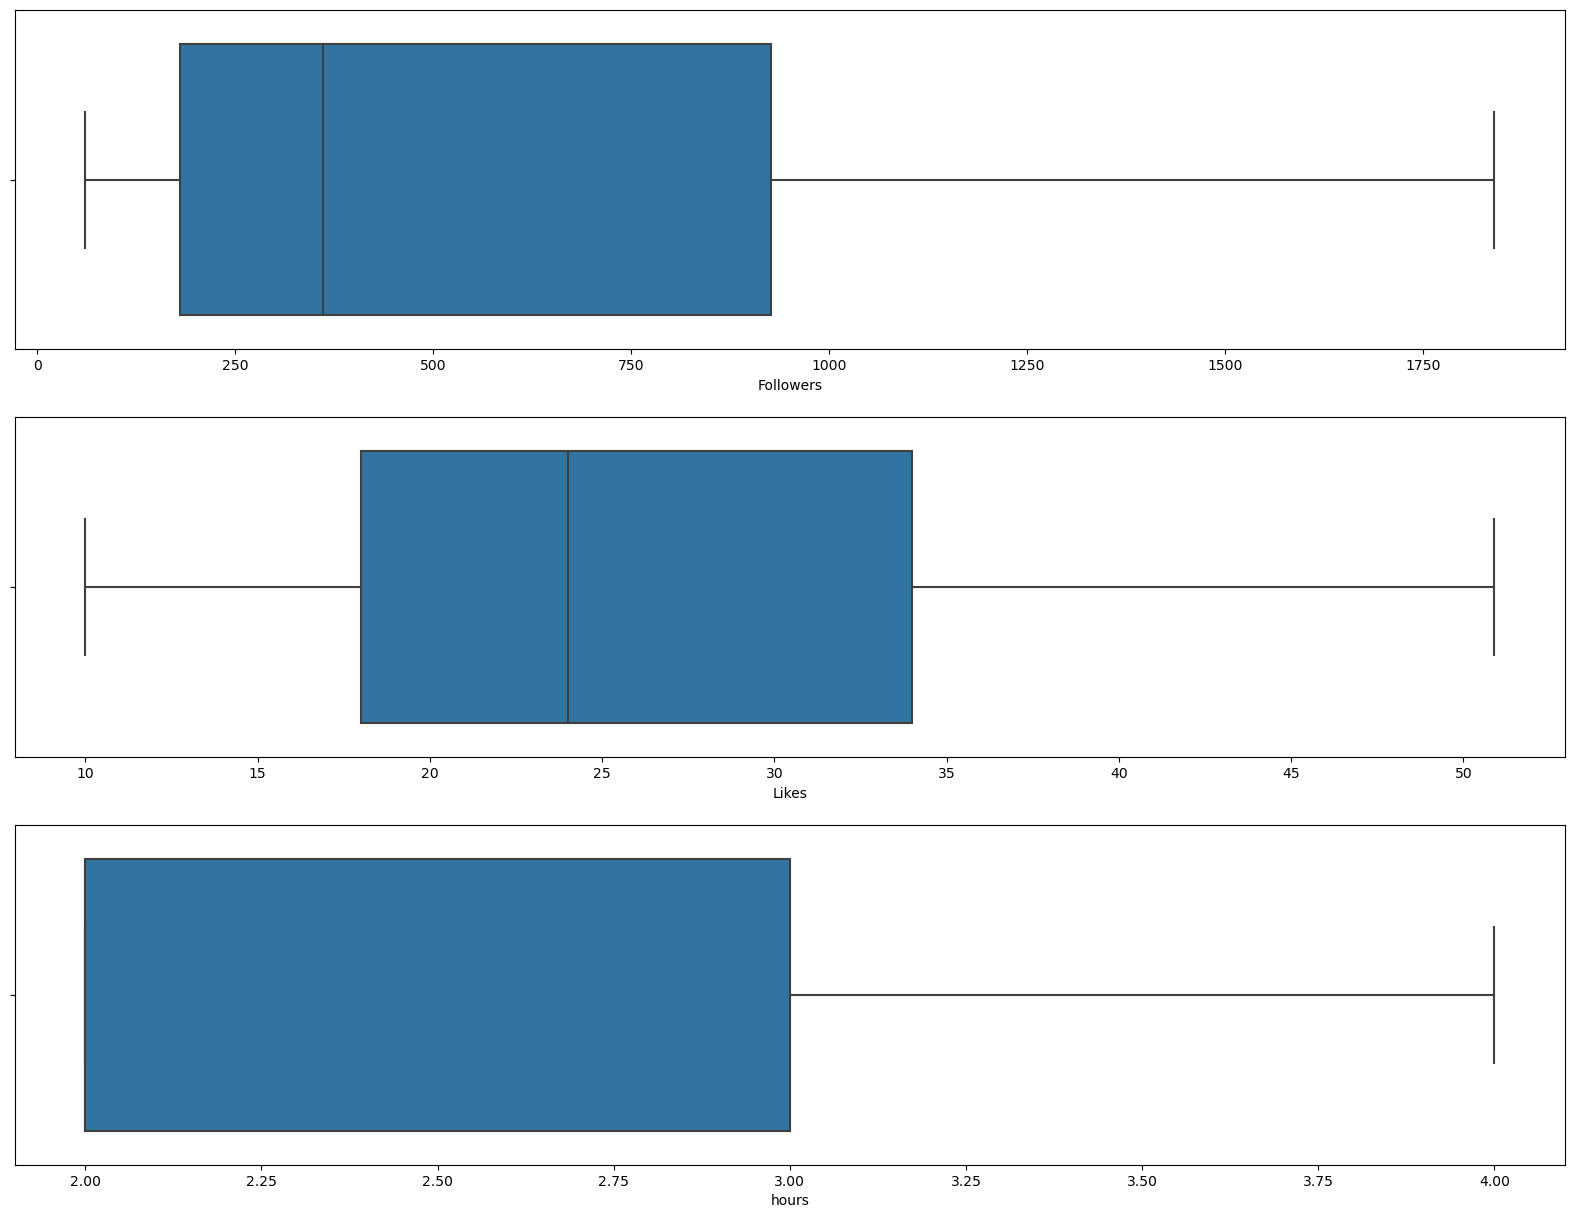

In [27]:
# Plot Boxplot of 'Followers', 'Likes', 'hours' column
numerical_col = ['Followers', 'Likes', 'hours']

fig = plt.figure(figsize=[20,15])
for i ,col in enumerate(numerical_col):  
    ax1 = fig.add_subplot(3,1, i+1);
    ax1 = sns.boxplot(data = data, x=col)

In [28]:
# Winsorization function to handle outliers in a column
# def handle_outliers(column):
#     # Calculate the lower and upper threshold
#     lower_threshold = np.percentile(column, 5)
#     upper_threshold = np.percentile(column, 95)
    
#     # Winsorize the column to replace outliers with nearest non-outlying values
#     winsorized_column = winsorize(column, limits=[0.05, 0.05])
    
#     return winsorized_column

# # Handle outliers in all three columns
# data['Likes'] = handle_outliers(data['Likes'])
# data['Followers'] = handle_outliers(data['Followers'])
# data['hours'] = handle_outliers(data['hours'])

In [29]:
data.columns

Index(['USERNAME', 'Caption', 'Followers', 'Hashtags', 'Likes', 'hours'], dtype='object')

In [30]:
# Converting Categorical data to numerical by replacing their length and counts
data['Caption_length'] = data['Caption'].apply(lambda x: len(str(x)))
data['Hashtags_count'] = data['Hashtags'].apply(lambda x: len(str(x).split()))

#Now drop 'Caption', 'Hashtags' column
data.drop(['Caption', 'Hashtags'], axis=1, inplace=True)

In [31]:
from sklearn import preprocessing   
  
lb = preprocessing.LabelEncoder()   
#labelencoding the username column
data[ 'USERNAME' ]= lb.fit_transform(data[ 'USERNAME' ])   

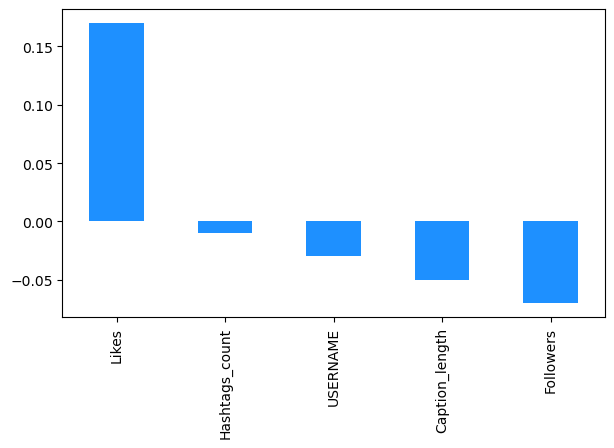

In [32]:
#Correlation Analysis

correlation = data.corr()

ax = round(correlation['hours'].sort_values(ascending = False)[1:] ,2 ).plot(kind = 'bar' ,color='dodgerblue' , figsize = (7,4))
plt.show() 

<AxesSubplot: >

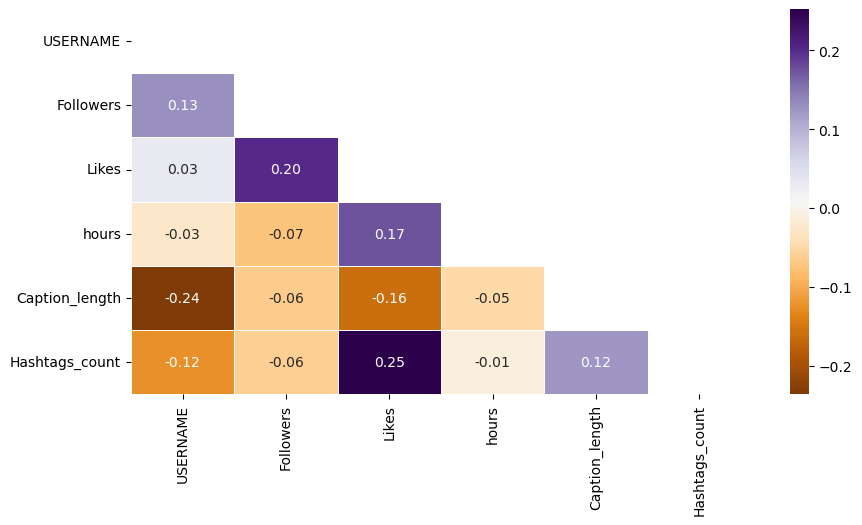

In [33]:
# Using Heatmap Correlation Analysis

plt.figure(figsize=(10, 5))
mask = np.triu(np.ones_like(correlation))
sns.heatmap(correlation,mask= mask, annot=True, fmt='.2f', linewidths=0.5, cmap='PuOr')

In [34]:
#Split the data
X = data[['USERNAME', 'Followers', 'Caption_length', 'Hashtags_count']]
y = data[['Likes', 'hours']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
data.head()

,USERNAME,Followers,Likes,hours,Caption_length,Hashtags_count
1,21,880.0,23.0,2.0,454,19
2,2,255.0,25.0,2.0,704,20
3,56,340.0,49.0,3.0,4,20
4,17,304.0,30.0,3.0,322,18
5,9,1231.0,18.0,3.0,348,23


In [36]:
#standardize or feature scaling the datasets

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

# for avoiding data leakage here we use transform not fit_transform
X_test = scaler.transform(X_test)

# Linear Regression

In [38]:
# Select a model
lin_model = LinearRegression()
# lin_hours = LinearRegression()

In [39]:
# Train the model

lin_model.fit(X_train, y_train)

LinearRegression()

In [40]:
# Make predictions
pred = lin_model.predict(X_test)

Text(0, 0.5, 'Test predicted data')

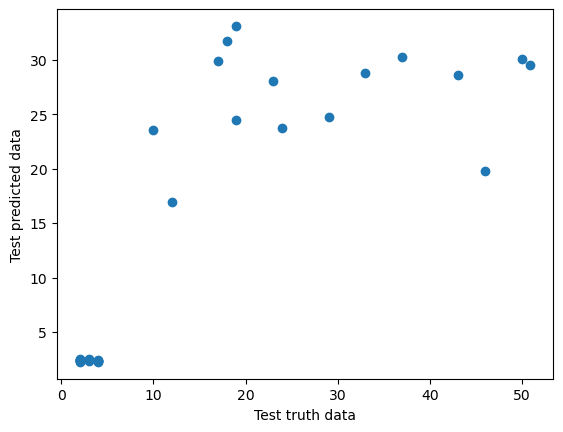

In [41]:
# visualize the relationship between the truth point and predicted point

plt.scatter(y_test, pred)       
plt.xlabel('Test truth data')
plt.ylabel('Test predicted data')

<AxesSubplot: ylabel='Density'>

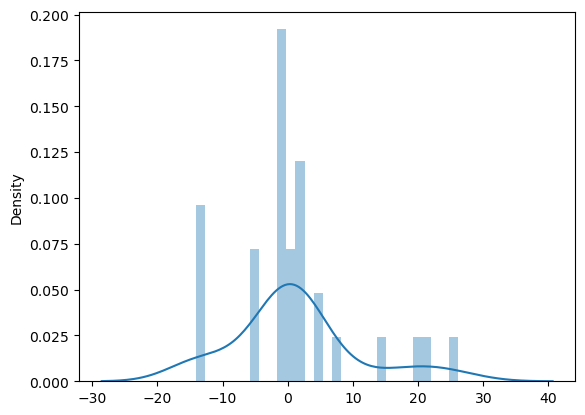

In [42]:
#Residuals
residuals = y_test - pred
sns.distplot(residuals)

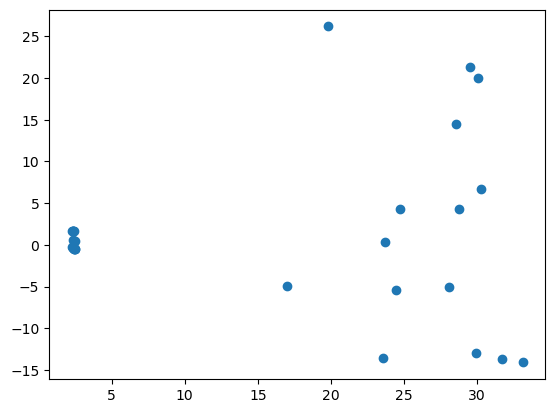

In [43]:
# scattter plot with predictions and residuals
#Check for Homoscedasticity
plt.scatter(pred, residuals)

In [44]:
# Evaluating the model performance
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
adj_r2 = 1 - (1-r2)*(len(y_test)-1) / (len(y_test) - X_test.shape[1]-1)

In [45]:
print(' MSE: {},\n MAE: {},\n R^2: {},\n adj_r2: {}'.format(mse, mae, r2, adj_r2))

 MSE: 88.77645393273478,
 MAE: 5.9983719890846565,
 R^2: -0.13215187828947178,
 adj_r2: -0.5850126296052605


# Decision Tree

In [46]:
# Fitting Decision Tree Regression to the dataset
from sklearn.tree import DecisionTreeRegressor
dt_regressor = DecisionTreeRegressor(max_depth=15,min_samples_leaf=300)
dt_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=300)

In [47]:
# Predicting the test set results
y_pred = dt_regressor.predict(X_test)

In [48]:
# Evaluating the model performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1-r2)*(len(y_test)-1) / (len(y_test) - X_test.shape[1]-1)

In [49]:
print(' MSE: {},\n MAE: {},\n R^2: {},\n adj_r2: {}'.format(mse, mae, r2, adj_r2))

 MSE: 91.59264583333332,
 MAE: 6.194277777777778,
 R^2: -0.11039763506315614,
 adj_r2: -0.5545566890884186


# Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100,max_depth=6, min_samples_leaf=50,n_jobs=4)

rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=50, n_jobs=4)

In [51]:
predictions=rf.predict(X_test)

In [52]:
# Evaluating the model performance
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
adj_r2 = 1 - (1-r2)*(len(y_test)-1) / (len(y_test) - X_test.shape[1]-1)

In [53]:
print(' MSE: {},\n MAE: {},\n R^2: {},\n adj_r2: {}'.format(mse, mae, r2, adj_r2))

 MSE: 91.92640087847218,
 MAE: 6.189247222222224,
 R^2: -0.11462123949790304,
 adj_r2: -0.560469735297064
